# Animal classification

## 0. Description

Let's make an application that identifies which animal appears in the picture given. We are going to get the data, train the model and put it into production.

## 1. Libraries

In [260]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier

import skimage

import tensorflow as tf
import tensorflow_hub as hub

## 2. Importing the data

### `2.1. Base case`

Veamos como se carga una sola imagen y se muestra en pantalla:

In [261]:
img=plt.imread('data/LionHead/lion007.jpg')
img.shape

(80, 80, 3)

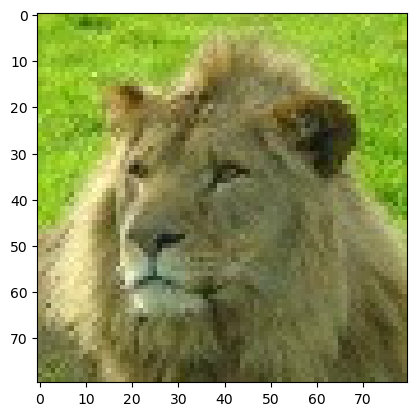

In [262]:
plt.imshow(img)

### `2.2. Real case`

Generamos dos listas, una con todas las imágenes cargadas con la ruta, y otra con las etiquetas, que serán las carpetas de nuestro directorio.

In [263]:
data=os.listdir('data')
img_list=[]
label_list=[]
for folder in data:
    for file in os.listdir('data/'+folder):
        if os.path.isfile('data/'+folder+'/'+file):
            img=plt.imread('data/'+folder+'/'+file)
            label_list.append(folder)
            img_list.append(img)

In [264]:
df=pd.DataFrame(data={"img":img_list,"label":label_list})
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 214,...",BearHead
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",BearHead
2,"[[[104, 109, 102], [104, 111, 103], [108, 115,...",BearHead
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",BearHead
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",BearHead


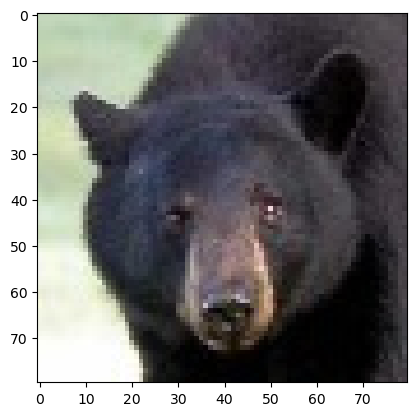

In [265]:
plt.imshow(df.loc[0,'img'])

### `2.3. Label names`

In [266]:
i=0
for word in df['label']:
    df.iloc[i,1]=word.replace('Head','')
    i+=1

In [267]:
df.label.unique()

array(['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle',
       'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Natural', 'Panda',
       'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf'], dtype=object)

In [268]:
df.shape

(2057, 2)

### `2.4. Trial`

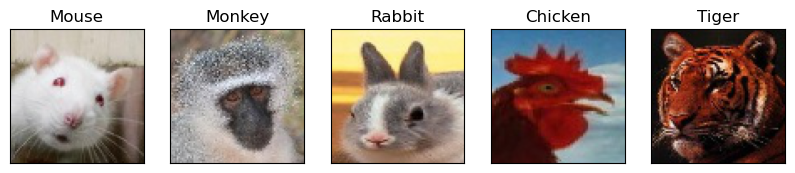

In [269]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,df.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(df.loc[j,'img'])
    plt.title(df.loc[j,'label'])

We can repeat this execution every time we want in order to check if the labels are right.

### `2.5. Data saving`

In [270]:
with open('pickle_files/diego_dataframe.pkl','wb') as f:
    pickle.dump(df,f)

## 3. Modeling

### `3.0. Label encoding`

In [271]:
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 214,...",Bear
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",Bear
2,"[[[104, 109, 102], [104, 111, 103], [108, 115,...",Bear
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",Bear
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",Bear


In [272]:
dict_labels={}
i=0
for label in df.label.unique():
    dict_labels[label]=i
    i+=1
print(dict_labels)

{'Bear': 0, 'Cat': 1, 'Chicken': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Duck': 6, 'Eagle': 7, 'Elephant': 8, 'Human': 9, 'Lion': 10, 'Monkey': 11, 'Mouse': 12, 'Natural': 13, 'Panda': 14, 'Pigeon': 15, 'Rabbit': 16, 'Sheep': 17, 'Tiger': 18, 'Wolf': 19}


In [273]:
mapeo={}
for key in dict_labels.keys():
    mapeo[dict_labels[key]]=key
print(mapeo)

{0: 'Bear', 1: 'Cat', 2: 'Chicken', 3: 'Cow', 4: 'Deer', 5: 'Dog', 6: 'Duck', 7: 'Eagle', 8: 'Elephant', 9: 'Human', 10: 'Lion', 11: 'Monkey', 12: 'Mouse', 13: 'Natural', 14: 'Panda', 15: 'Pigeon', 16: 'Rabbit', 17: 'Sheep', 18: 'Tiger', 19: 'Wolf'}


Let's save the mapping

In [274]:
with open('pickle_files/diego_mapeo.pkl','wb') as f:
    pickle.dump(mapeo,f)

In [275]:
df["label_2"]=0

In [276]:
for i in range(df.shape[0]):
    df.iloc[i,2]=dict_labels[df.iloc[i,1]]
df.sample(5)

,img,label,label_2
1662,"[[[69, 131, 20], [64, 127, 13], [62, 125, 11],...",Rabbit,16
1011,"[[[246, 247, 252], [241, 242, 247], [245, 246,...",Human,9
1840,"[[[52, 85, 28], [75, 106, 47], [88, 117, 59], ...",Sheep,17
306,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Chicken,2
681,"[[[100, 85, 52], [101, 86, 53], [103, 88, 55],...",Dog,5


In [277]:
df["label"]=df["label_2"]
df.drop(columns=["label_2"],inplace=True)
df.sample(5)

,img,label
1677,"[[[19, 20, 22], [19, 20, 22], [19, 20, 22], [1...",16
1207,"[[[36, 31, 25], [41, 34, 28], [55, 46, 41], [4...",11
1014,"[[[165, 173, 175], [179, 187, 189], [193, 198,...",9
1785,"[[[59, 53, 41], [62, 56, 44], [65, 59, 47], [7...",17
717,"[[[114, 107, 89], [119, 112, 94], [118, 111, 9...",6


### ``3.1. Data split``

In [278]:
x_train,x_test,y_train,y_test=train_test_split(df['img'],df['label'],test_size=0.2,random_state=42)

In [279]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645,), (412,), (1645,), (412,))

We need to change the format of the images.

In [280]:
x_train=np.array(x_train.tolist())
x_test=np.array(x_test.tolist())
x_train.shape,x_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3))

In [281]:
y_train

67       0
1001     9
567      5
1271    11
1666    16
        ..
1638    15
1095     9
1130    10
1294    11
860      7
Name: label, Length: 1645, dtype: int64

### `3.2. Encoding`

In [282]:
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)
type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray)

In [283]:
x_train=np.array(x_train/255)
x_test=np.array(x_test/255)
type(x_train),type(x_test)

(numpy.ndarray, numpy.ndarray)

In [284]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3), (1645,), (412,))

### ``3.3. Modeling and training``

#### First neural network (linear regression)

In [285]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [286]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [287]:
history = model.fit(x_train,y_train,epochs=30,use_multiprocessing=False, verbose=False,
                    validation_data=(x_test, y_test))
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

52/52 [==============================] - 0s 4ms/step - loss: 0.3551 - accuracy: 0.8918
Training Accuracy: 0.8918


In [288]:
def training_plot( metricas, history):
    plt.figure(figsize=(10,3))
    for i,metrica in enumerate(metricas):
        plt.subplot(1,2,i+1)
        y = history.history[metrica]
        x = [ x+1 for x in range( len( history.history[metrica] ))]
        plt.plot(x,y)
        y = history.history[f'val_{metrica}']
        x = [ x+1 for x in range( len( history.history[f'val_{metrica}'] ))]
        plt.plot(x,y)
        plt.title(metrica)
        plt.legend([f'{metrica}',f'val_{metrica}'])

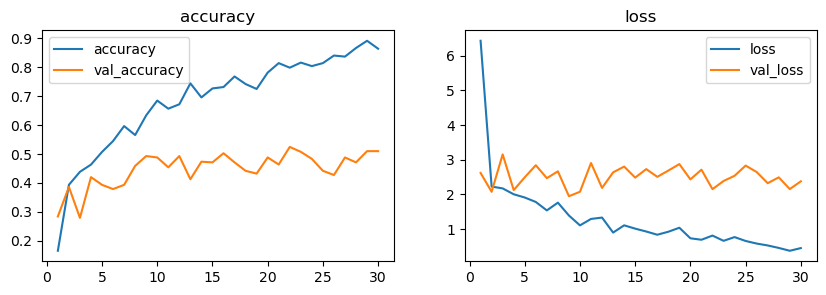

In [289]:
training_plot(['accuracy','loss'],history)

#### Let's define a new neural network now.

In [290]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [291]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [292]:
history = model.fit(x_train,y_train,epochs=10,use_multiprocessing=False,
                    validation_data=(x_test, y_test),batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/10
13/13 [==============================] - 3s 164ms/step - loss: 4.3185 - accuracy: 0.1058 - val_loss: 2.7461 - val_accuracy: 0.2257
Epoch 2/10
13/13 [==============================] - 2s 176ms/step - loss: 2.7017 - accuracy: 0.2024 - val_loss: 2.5341 - val_accuracy: 0.2257
Epoch 3/10
13/13 [==============================] - 3s 201ms/step - loss: 2.3733 - accuracy: 0.2845 - val_loss: 2.4344 - val_accuracy: 0.3107
Epoch 4/10
13/13 [==============================] - 2s 191ms/step - loss: 2.2688 - accuracy: 0.3258 - val_loss: 2.2766 - val_accuracy: 0.3471
Epoch 5/10
13/13 [==============================] - 2s 180ms/step - loss: 2.0929 - accuracy: 0.3933 - val_loss: 2.1063 - val_accuracy: 0.4175
Epoch 6/10
13/13 [==============================] - 2s 168ms/step - loss: 1.9588 - accuracy: 0.4401 - val_loss: 2.0432 - val_accuracy: 0.4175
Epoch 7/10
13/13 [==============================] - 2s 146ms/step - loss: 1.9055 - accuracy: 0.4614 - val_loss: 2.0782 - val_accuracy: 0.3932
Epoch 

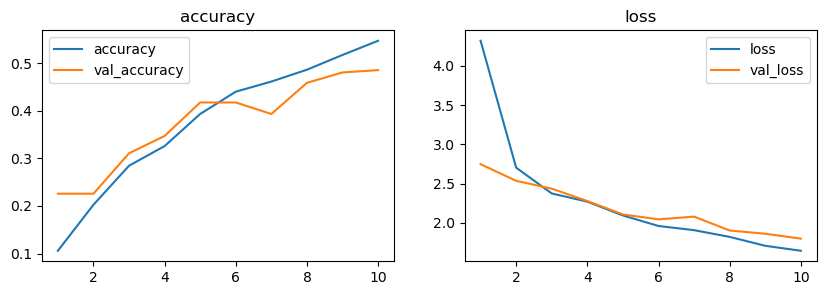

In [293]:
training_plot(['accuracy','loss'],history)

#### Deep neural network (more than one hidden layer)

In [294]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [295]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [296]:
history = model.fit(x_train,y_train,epochs=20,use_multiprocessing=False,
                    validation_data=(x_test, y_test),batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20


13/13 [==============================] - 3s 218ms/step - loss: 3.2671 - accuracy: 0.1027 - val_loss: 2.7335 - val_accuracy: 0.1214
Epoch 2/20
13/13 [==============================] - 2s 180ms/step - loss: 2.7303 - accuracy: 0.1678 - val_loss: 2.5021 - val_accuracy: 0.2306
Epoch 3/20
13/13 [==============================] - 2s 187ms/step - loss: 2.5300 - accuracy: 0.2334 - val_loss: 2.3741 - val_accuracy: 0.2961
Epoch 4/20
13/13 [==============================] - 2s 181ms/step - loss: 2.3768 - accuracy: 0.2705 - val_loss: 2.2624 - val_accuracy: 0.3617
Epoch 5/20
13/13 [==============================] - 2s 164ms/step - loss: 2.2705 - accuracy: 0.3362 - val_loss: 2.1382 - val_accuracy: 0.3762
Epoch 6/20
13/13 [==============================] - 2s 164ms/step - loss: 2.1649 - accuracy: 0.3611 - val_loss: 2.0880 - val_accuracy: 0.3956
Epoch 7/20
13/13 [==============================] - 2s 162ms/step - loss: 2.0779 - accuracy: 0.3757 - val_loss: 1.9953 - val_accuracy: 0.4417
Epoch 8/20
13/13 

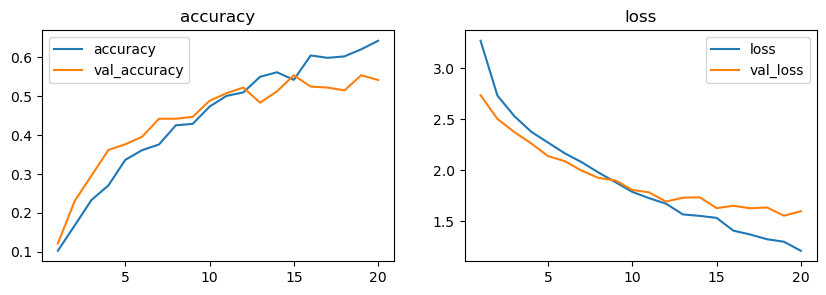

In [297]:
training_plot(['accuracy','loss'],history)

#### Convolutional neural network

In [298]:
layers=[]

layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(80,80,3)))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))
layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))

layers.append(tf.keras.layers.Flatten())
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [299]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [300]:
history = model.fit(x_train,y_train,epochs=20,use_multiprocessing=False,
                    validation_data=(x_test, y_test),batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20


13/13 [==============================] - 11s 765ms/step - loss: 2.9113 - accuracy: 0.1094 - val_loss: 2.8198 - val_accuracy: 0.1796
Epoch 2/20
13/13 [==============================] - 8s 594ms/step - loss: 2.6697 - accuracy: 0.2061 - val_loss: 2.4939 - val_accuracy: 0.3107
Epoch 3/20
13/13 [==============================] - 8s 581ms/step - loss: 2.3479 - accuracy: 0.3283 - val_loss: 2.2076 - val_accuracy: 0.3495
Epoch 4/20
13/13 [==============================] - 8s 580ms/step - loss: 2.0916 - accuracy: 0.3988 - val_loss: 1.9159 - val_accuracy: 0.4733
Epoch 5/20
13/13 [==============================] - 7s 580ms/step - loss: 1.8487 - accuracy: 0.4699 - val_loss: 1.7068 - val_accuracy: 0.5413
Epoch 6/20
13/13 [==============================] - 7s 572ms/step - loss: 1.5970 - accuracy: 0.5435 - val_loss: 1.5429 - val_accuracy: 0.5728
Epoch 7/20
13/13 [==============================] - 7s 583ms/step - loss: 1.4503 - accuracy: 0.5836 - val_loss: 1.4476 - val_accuracy: 0.5777
Epoch 8/20
13/13

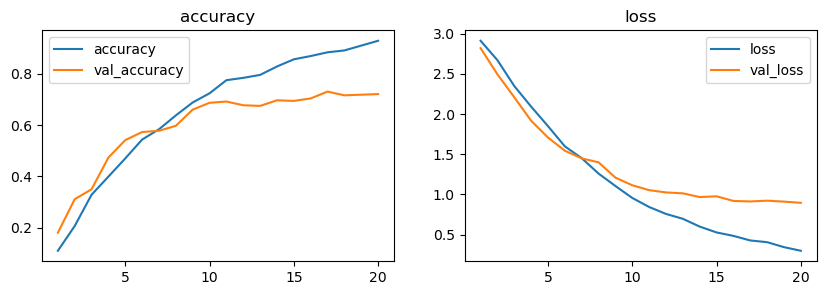

In [301]:
training_plot(['accuracy','loss'],history)

Let's save the model

In [302]:
model.save('model/model.h5')

## 4. Testing

### `4.1. Simple testing`

In [303]:
predictions=model.predict(x_test)


13/13 [==============================] - 1s 56ms/step


In [304]:
predictions.shape

(412, 20)

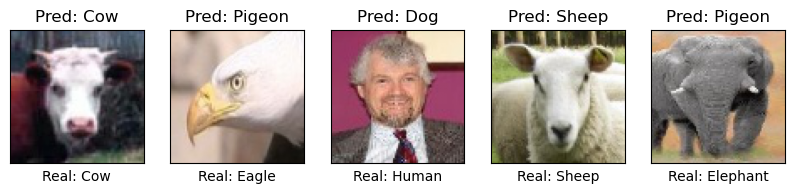

In [305]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,x_test.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[j])
    plt.title(f'Pred: {mapeo[np.argmax(predictions[j])]}')
    plt.xlabel(f'Real: {mapeo[y_test[j]]}')
plt.show()

In [306]:
print(f'Accuracy: {np.sum(np.argmax(predictions,axis=1)==y_test)/y_test.shape[0]}')
print(f'Error: {np.sum(np.argmax(predictions,axis=1)!=y_test)/y_test.shape[0]}')

Accuracy: 0.720873786407767
Error: 0.279126213592233


In [307]:
df_pred=pd.DataFrame(data={'pred':np.argmax(predictions,axis=1),'real':y_test})
df_pred.head()

,pred,real
0,8,1
1,18,18
2,1,1
3,10,10
4,14,14


In [308]:
df_pred["real"]=df_pred["real"].apply(lambda x: mapeo[x])
df_pred["pred"]=df_pred["pred"].apply(lambda x: mapeo[x])

In [309]:
df_pred.head()

,pred,real
0,Elephant,Cat
1,Tiger,Tiger
2,Cat,Cat
3,Lion,Lion
4,Panda,Panda


In [310]:
df_pred["exito"]=(df_pred["real"]==df_pred["pred"]).astype(int)

In [311]:
df_pred.exito.value_counts()

1    297
0    115
Name: exito, dtype: int64

Let's see it in a confussion matrix, which shows how many predictions there were for each label

In [312]:
pd.crosstab(df_pred['real'],df_pred['pred'],margins=True)

pred,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf,All
real,,,,,,,,,,,,,,,,,,,,
Bear,13,1,0,1,1,1,1,0,0,0,2,0,0,0,0,0,0,0,0,20
Cat,0,27,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,33
Chicken,0,0,23,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,25
Cow,0,1,0,12,1,2,0,1,1,1,0,1,0,0,0,0,2,0,0,22
Deer,0,0,0,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23
Dog,0,2,1,1,0,15,2,0,1,0,0,0,1,0,0,1,0,0,0,24
Duck,0,1,0,0,0,0,16,0,0,0,0,1,0,0,2,0,0,0,0,20
Eagle,0,0,0,0,0,0,1,9,0,0,0,1,1,1,6,0,0,0,0,19
Elephant,0,2,0,1,0,1,0,0,20,0,0,0,0,0,1,0,0,0,0,25


In [313]:
import sklearn.metrics as metrics

In [314]:
pd.DataFrame(metrics.classification_report(df_pred['real'],df_pred['pred'],output_dict=True)).T.sort_values(by='f1-score',ascending=False)

c:\Users\diego\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diego\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diego\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Human,0.9500,0.9500,0.9500,20.0000
Chicken,0.9583,0.9200,0.9388,25.0000
Deer,0.9167,0.9565,0.9362,23.0000
Panda,0.8947,0.9444,0.9189,18.0000
Tiger,0.7895,0.8824,0.8333,17.0000
Elephant,0.8000,0.8000,0.8000,25.0000
Wolf,0.9474,0.6923,0.8000,26.0000
accuracy,0.7209,0.7209,0.7209,0.7209
Cat,0.6429,0.8182,0.7200,33.0000
weighted avg,0.7345,0.7209,0.7170,412.0000


In [315]:
pd.options.display.float_format = '{:.4f}'.format
df_proba=pd.DataFrame(predictions,columns=[mapeo[i] for i in range(20)])
df_proba

,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Natural,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf
0,0.0036,0.0698,0.0016,0.0115,0.0035,0.1405,0.1136,0.0094,0.2508,0.0270,0.0489,0.0235,0.0597,0.0401,0.0000,0.0313,0.1321,0.0017,0.0143,0.0170
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.9994,0.0000
2,0.0001,0.9940,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0024,0.0000,0.0024,0.0000,0.0007,0.0001,0.0000,0.0000
3,0.0202,0.0038,0.0021,0.0192,0.0004,0.0031,0.0093,0.0014,0.0123,0.0031,0.9077,0.0056,0.0009,0.0018,0.0002,0.0005,0.0052,0.0001,0.0032,0.0001
4,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.0137,0.0105,0.0001,0.0063,0.0025,0.0275,0.0030,0.0002,0.0160,0.0001,0.0070,0.6137,0.0150,0.0070,0.0001,0.1370,0.1178,0.0002,0.0203,0.0019
408,0.0000,0.0000,0.9971,0.0005,0.0001,0.0001,0.0001,0.0001,0.0000,0.0002,0.0001,0.0006,0.0007,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000
409,0.0035,0.0232,0.0003,0.0165,0.0013,0.0043,0.0000,0.0001,0.0133,0.0000,0.8739,0.0448,0.0002,0.0089,0.0011,0.0000,0.0008,0.0000,0.0027,0.0051
410,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9996,0.0000,0.0000,0.0000,0.0000,0.0000


### `4.2. Bear or not`

Let's analyse it as a binary classification problem (bear or not) 

In [316]:
y_test_s=pd.Series(y_test)
y_test_s=y_test_s.apply(lambda x: mapeo[x])
y_test_s

0          Cat
1        Tiger
2          Cat
3         Lion
4        Panda
        ...   
407     Monkey
408    Chicken
409       Lion
410      Panda
411      Mouse
Length: 412, dtype: object

In [317]:
y_test_s=(y_test_s=="Bear").astype(int)
y_test_s

0      0
1      0
2      0
3      0
4      0
      ..
407    0
408    0
409    0
410    0
411    0
Length: 412, dtype: int32

In [318]:
y_test_s.value_counts()

0    392
1     20
dtype: int64

C:\Users\diego\AppData\Local\Temp\ipykernel_18560\882954125.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
C:\Users\diego\AppData\Local\Temp\ipykernel_18560\882954125.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--',color='blue')


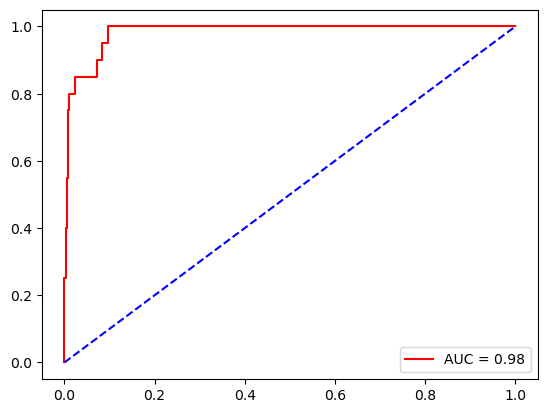

In [319]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_s, df_proba['Bear'])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='blue')

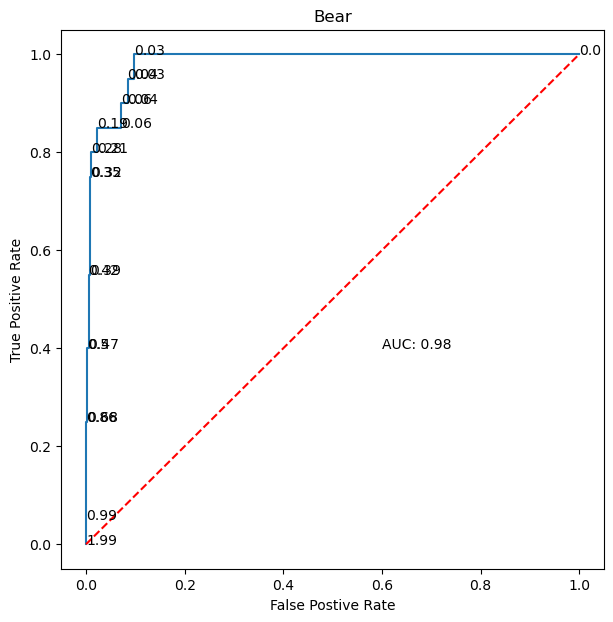

In [320]:
plt.figure(figsize=(7,7))
fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba['Bear'] )
metrica_auc = metrics.auc(fpr, tpr)
plt.plot( fpr, tpr ) 
plt.plot([0,1],[0,1], color='Red', linestyle='--')
plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.6,0.4])
plt.title('Bear')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
for x in range( len(_)):
    plt.annotate( round(_[x],2), [ fpr[x], tpr[x] ])

In [321]:
np.round(_*100,2)

array([199.16,  99.16,  85.73,  67.6 ,  50.03,  46.68,  41.88,  39.08,
        34.61,  32.32,  28.31,  20.51,  18.75,   5.73,   5.67,   4.34,
         3.96,   2.81,   2.64,   0.  ], dtype=float32)

Let's set a threshold of 30%.

In [322]:
y_pred_s_30=(df_proba['Bear']>0.3).astype(int)
y_pred_s_30.value_counts()

0    393
1     19
Name: Bear, dtype: int64

In [323]:
y_test_s_30=(y_test_s==1).astype(int)
y_test_s_30.value_counts()

0    392
1     20
dtype: int64

In [324]:
pd.crosstab(y_test_s,y_pred_s_30, margins= True )

Bear,0,1,All
row_0,,,
0,388,4,392
1,5,15,20
All,393,19,412


In [325]:
print(f'The accuracy of the model is: {metrics.accuracy_score(y_test_s,y_pred_s_30)}')
print(f'The precision of the model is: {metrics.precision_score(y_test_s,y_pred_s_30)}')
print(f'The recall of the model is: {metrics.recall_score(y_test_s,y_pred_s_30)}')

The accuracy of the model is: 0.9781553398058253
The precision of the model is: 0.7894736842105263
The recall of the model is: 0.75


### `4.3. For all labels`

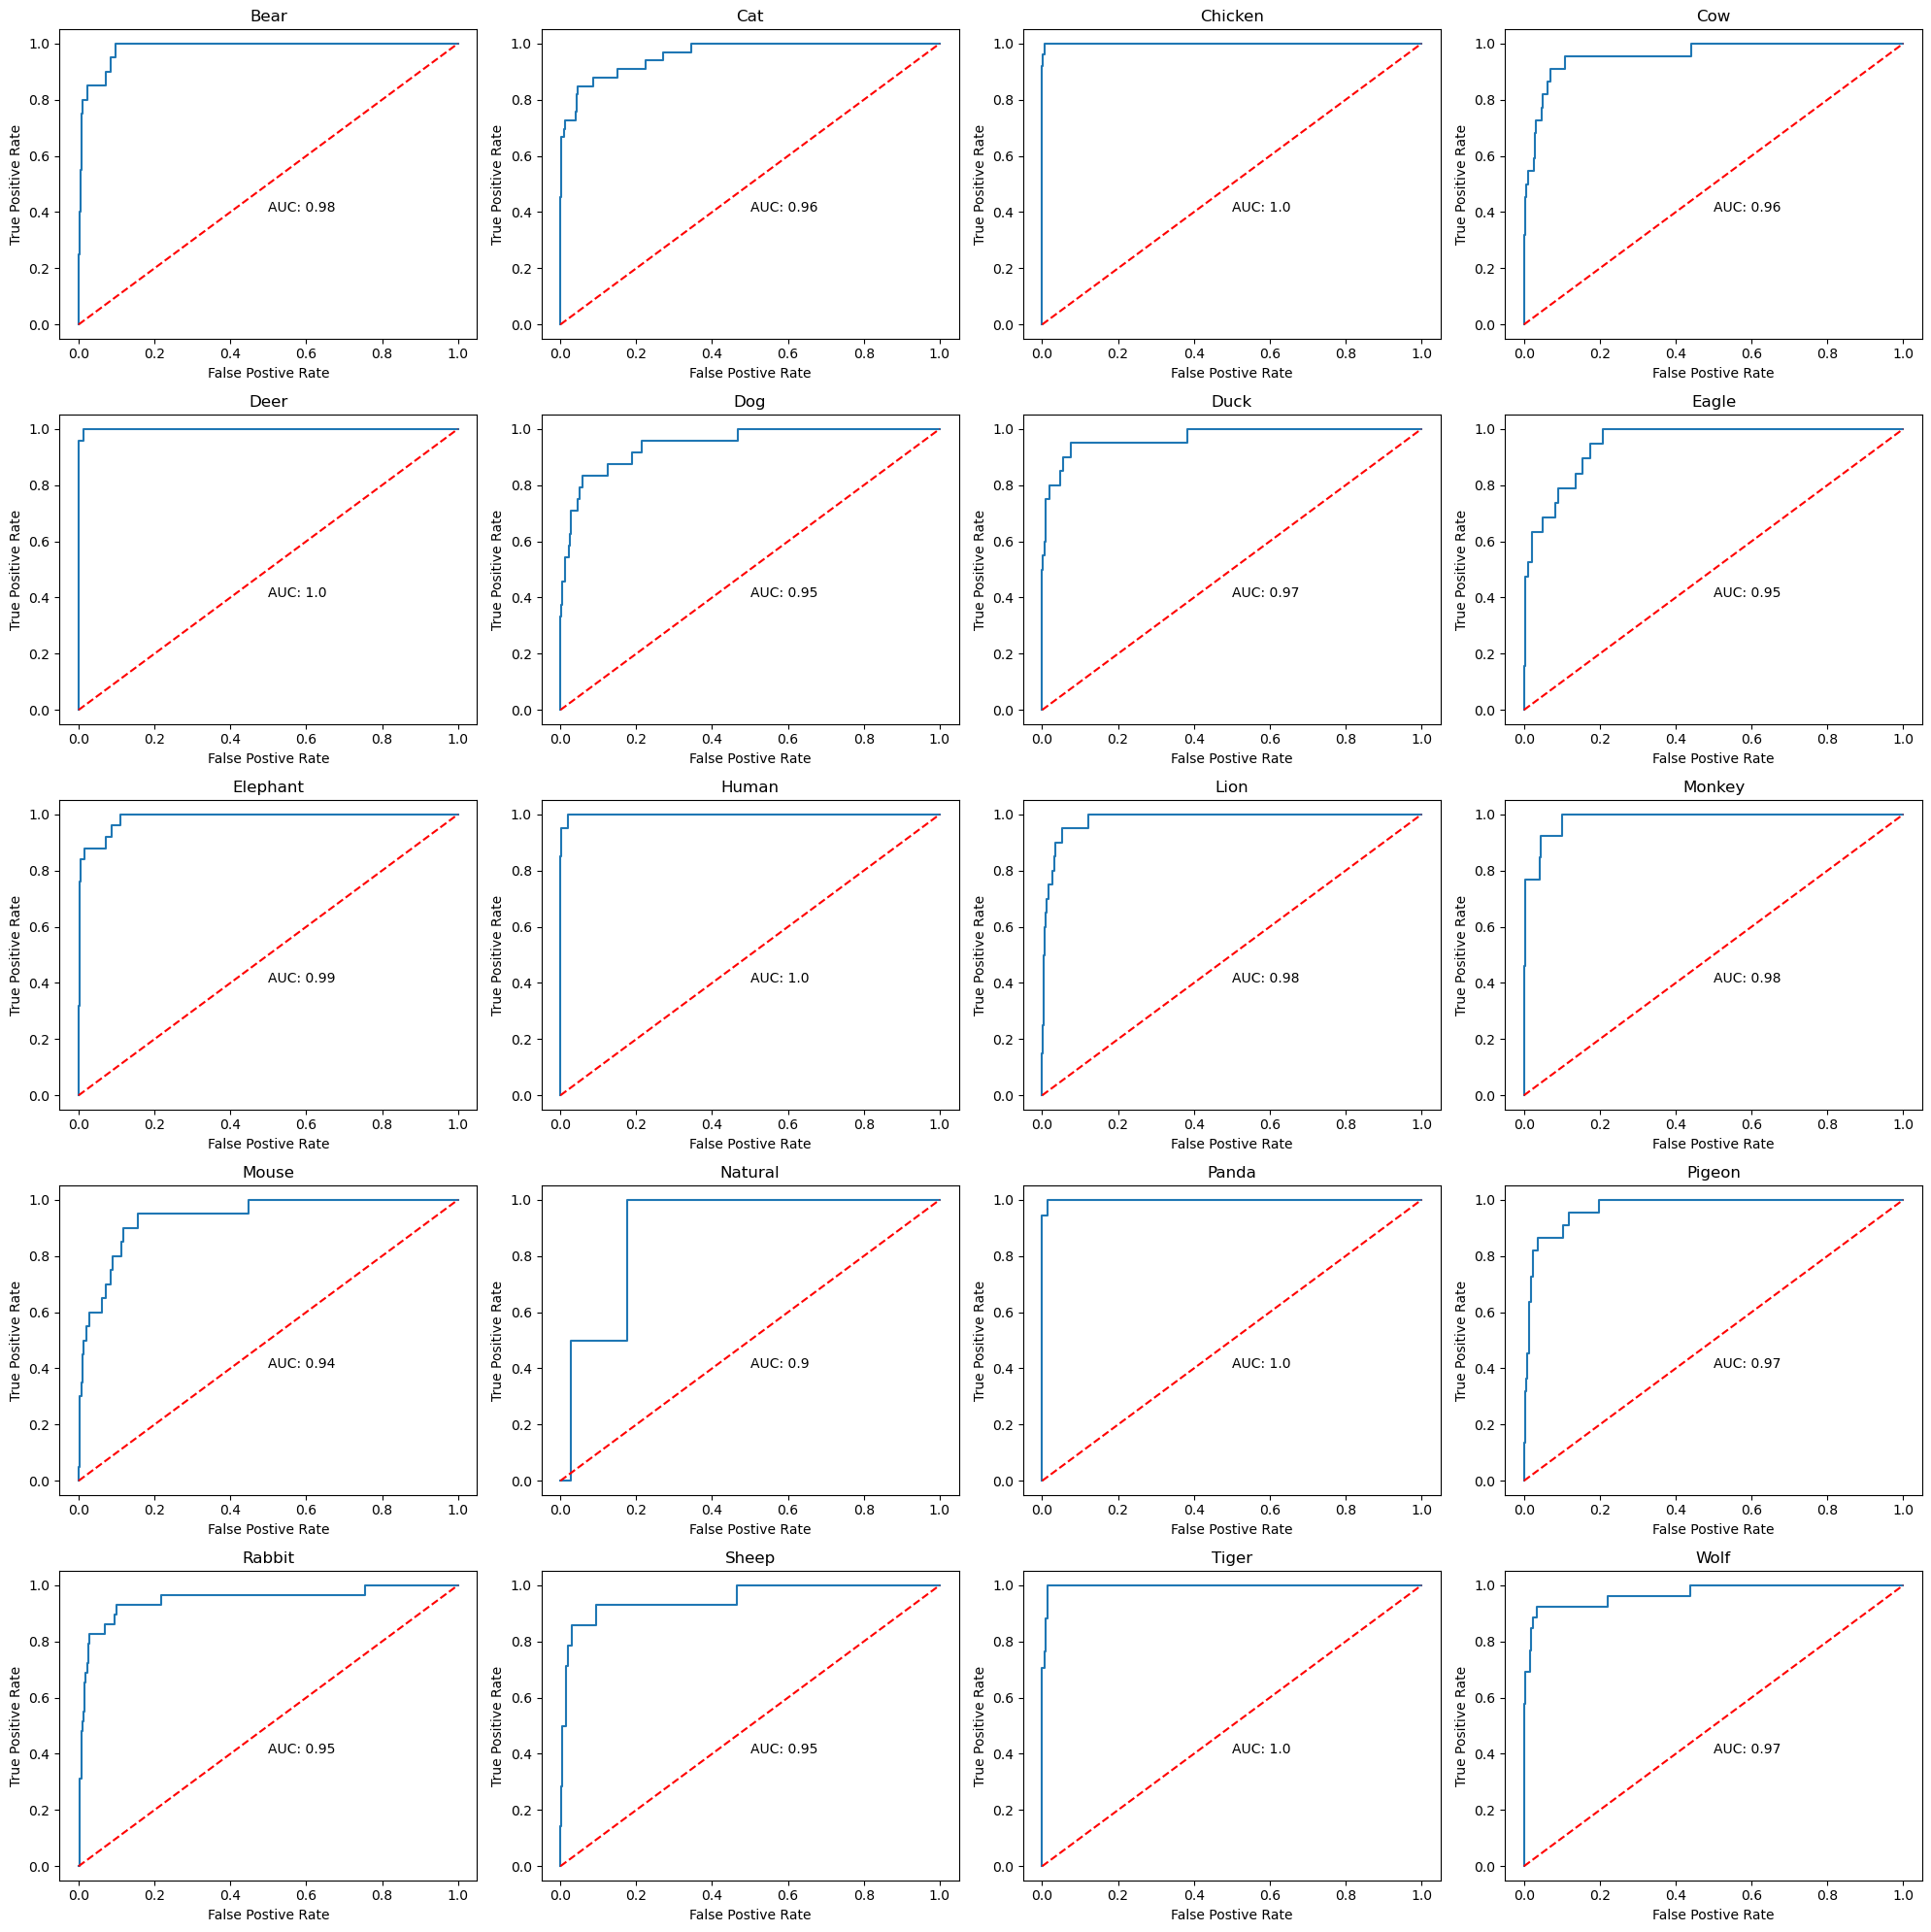

In [326]:
plt.figure(figsize=(20,20))
for i,clase in enumerate(mapeo.values()):
    plt.subplot(5,4,i+1)
    y_test_s=pd.Series(y_test)
    y_test_s=y_test_s.apply(lambda x: mapeo[x])
    y_test_s=(y_test_s==clase).astype(int)
    fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba[clase] )
    metrica_auc = metrics.auc(fpr, tpr)
    plt.plot( fpr, tpr ) 
    plt.plot([0,1],[0,1], color='Red', linestyle='--')
    plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.5,0.4])
    plt.title(clase)
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
plt.tight_layout()

### ``4.4. Other images prediction``

We have some other images in the folde Images. Let's see if our model can identify them correctly.

In [327]:
def model_pipeline(file_path,mapping,model):
    img_path=file_path
    img=plt.imread(img_path)
    img=skimage.transform.resize(img,(80,80,3))
    img=np.array(img)
    predict=model.predict(img.reshape(1,80,80,3),verbose=False)
    results_s=(pd.Series(predict[0],index=[mapping[i] for i in range(20)]).sort_values(ascending=False)[:5]*100).to_dict()
    for key in results_s:
        results_s[key]=round(results_s[key],2)
    return results_s

In [328]:
model_pipeline('Images/eagle.jpg',mapeo,model)

{'Eagle': 95.58, 'Panda': 2.73, 'Duck': 0.46, 'Cat': 0.35, 'Monkey': 0.16}

In [329]:
model_pipeline('Images/lion.jpg',mapeo,model)

{'Duck': 50.83, 'Chicken': 26.36, 'Monkey': 13.78, 'Human': 7.55, 'Cow': 0.53}

In [330]:
model_pipeline('Images/dog_test.jpg',mapeo,model)

{'Monkey': 28.48,
 'Rabbit': 24.91,
 'Mouse': 23.54,
 'Cow': 10.33,
 'Chicken': 7.75}

## 5. Transfer Learning

In order to get higher accuracy, let's upload a better model from tensorflow and combine it with our data and prediction settings.

It is better to upload the model instead of calling your web address because we do not know if the server might crash or not.

We are uploading the images again because we need to reshape them to 224x224.

In [331]:
IMG_WEIGHT=224
IMG_WIDTH=224
IMG_CHANNELS=3
def read_and_decode(filename,reshape_dims):
    img=tf.io.read_file(filename)
    img=tf.image.decode_jpeg(img,channels=IMG_CHANNELS)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return tf.image.resize(img,reshape_dims)

In [332]:
file_list=['data/'+path+'/'+file for path in os.listdir('data') for file in os.listdir ('data/'+path)]
len(file_list)

2057

In [333]:
img=read_and_decode(file_list[0],[IMG_WEIGHT,IMG_WIDTH])
img.shape

TensorShape([224, 224, 3])

In [334]:
img_tf=[read_and_decode(file,[IMG_WEIGHT,IMG_WIDTH]) for file in file_list]
img_np=np.array(img_tf)
img_np.shape

(2057, 224, 224, 3)

In [335]:
target=[img[img.find('/')+1:img.rfind('/')-4] for img in file_list]
len(target)

2057

In [336]:
x=img_np
y=target

In [337]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [338]:
encoder=LabelEncoder()
encoder.fit(y_train)

y_train=encoder.transform(y_train)
y_test=encoder.transform(y_test)

In [339]:
def training_plot(metrics,history):
    f,ax=plt.subplots(1,len(metrics),figsize=(10,3))
    for idx,metric in enumerate(['loss','accuracy']):
        ax[idx].plot([x for x in range(1,len(history.history[metric])+1)],history.history[metric])
        ax[idx].plot([ x for x in range(1,len(history.history[f'val_{metric}'])+1)],history.history[f'val_{metric}'])
        ax[idx].legend([metric, f'val_{metric}'],fontsize=9)

In [340]:
layers=[]
layers.append(hub.KerasLayer('./keras_layer', input_shape=(224,224,3),trainable=False,name='mobilenet_embedding'))

layers.append(tf.keras.layers.Dense(500,activation='relu',name='H1_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(200,activation='relu',name='H2_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(20,activation='softmax',name='Clasification_layer'))

model=tf.keras.Sequential(layers)

In [341]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [342]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 H1_layer (Dense)            (None, 500)               640500    
                                                                 
 dropout_25 (Dropout)        (None, 500)               0         
                                                                 
 H2_layer (Dense)            (None, 200)               100200    
                                                                 
 dropout_26 (Dropout)        (None, 200)               0         
                                                                 
 Clasification_layer (Dense)  (None, 20)               4020      
                                                     

In [343]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10


26/26 [==============================] - 37s 1s/step - loss: 1.0835 - accuracy: 0.6954 - val_loss: 0.2224 - val_accuracy: 0.9296
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.2042 - accuracy: 0.9374 - val_loss: 0.1713 - val_accuracy: 0.9539
Epoch 3/10
26/26 [==============================] - 22s 842ms/step - loss: 0.1183 - accuracy: 0.9623 - val_loss: 0.1669 - val_accuracy: 0.9393
Epoch 4/10
26/26 [==============================] - 21s 819ms/step - loss: 0.0695 - accuracy: 0.9781 - val_loss: 0.1386 - val_accuracy: 0.9587
Epoch 5/10
26/26 [==============================] - 18s 707ms/step - loss: 0.0424 - accuracy: 0.9884 - val_loss: 0.0973 - val_accuracy: 0.9684
Epoch 6/10
26/26 [==============================] - 19s 742ms/step - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.1609 - val_accuracy: 0.9563
Epoch 7/10
26/26 [==============================] - 21s 811ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.1530 - val_accuracy: 0.9490
Epoch 8/10
26/26

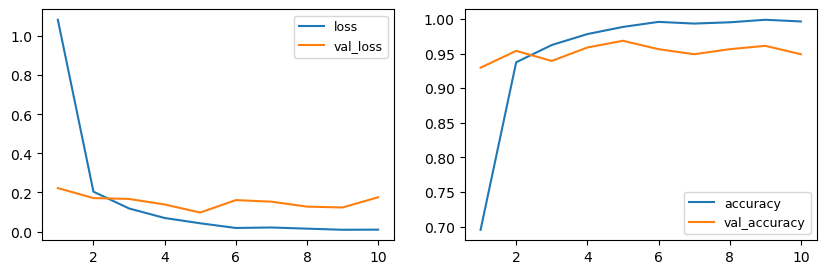

In [344]:
training_plot(['loss','accuracy'],history)

We are going to save the model.

In [345]:
model.save('model/model_tf.h5')